# Volume 1: K-Means Clustering.
    <Quin Daly>
    <Math 403>
    <12/06/21>

In [265]:
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
import imageio
%matplotlib inline

In [4]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.
Return `self` after completing this process.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster. It should look similar to the graphs in the lab.

In [253]:
class KMeans:
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, p=2, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
            p (float): The norm to use
            normalize (bool): Whether to normalize the centers at each step
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.p = p
        self.normalize = normalize
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        # Randomly select n_clusters centers
        idx = np.random.randint(X.shape[0], size=self.n_clusters)
        centers = X[idx, :]
        
        # Find distance between centers and all points, then find center w/ min dist.
        distances = cdist(X, centers, p=self.p)
        pts = np.array([np.argmin(i) for i in distances])
        
        # Run the k-means iteration
        for i in range(self.max_iter):
            centers = []
            for idx in range(self.n_clusters):
                # update centers by finding means of clusters
                new_centers = X[pts==idx].mean(axis=0)
                centers.append(new_centers)
            
            # update centers
            centers = np.vstack(centers)
            #if self.normalize == True:
                #centers = normalize(centers, norm='l1')
                
            distances = cdist(X, centers, 'euclidean')
            pts = np.array([np.argmin(i) for i in distances])
            if np.linalg.norm(centers) < self.tol:
                break
        
        self.centers = centers
        self.pts = pts
        self.distances = distances
                    
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters-1 for each entry of X.
        """
        # return the points from the fit() method to show the clusters each pt belongs to
        return self.pts
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

In [254]:
#run this cell to get the iris data
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = PCA(n_components=2).fit_transform(iris.data)

In [255]:
# Run the class
k_means = KMeans(n_clusters=3)
k_means.fit(iris_data)
clusterings = k_means.predict(iris_data)

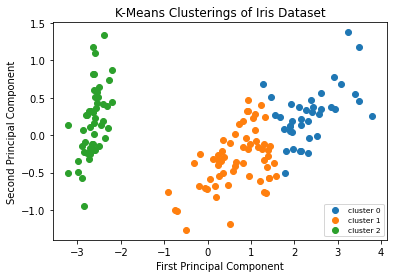

In [256]:
# plot the different clusters
u_labels = np.unique(clusterings)
for i in u_labels:
    plt.scatter(iris_data[clusterings == i, 0], iris_data[clusterings == i, 1], label = 'cluster ' + str(i))
    
plt.legend(prop={'size': 7.5})
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clusterings of Iris Dataset')
plt.show()

## Problem 2

Modify `KMeansfit()` to take in a paramter `p` which gives us the norm to be used. 

Import and parse the Sacramento housing data.
1. Use your `KMeans` class with a chosen `norm` on the housing data, let n=12.
2. Experiment with different norms.
3. Plot the data, coloring by cluster.
Also mark the cluster centers.
In a Markdown cell explain which norm is best for decreasing the longest distance to farthest home.

In [86]:
df = np.load('sacramento.npy')
X = df[:,-2:]

In [108]:
k_means = KMeans(p=2)
k_means.fit(X)
clusterings = k_means.predict(X)

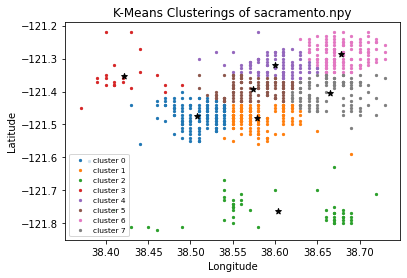

In [109]:
# plot the different clusters
u_labels = np.unique(clusterings)
for i in u_labels:
    plt.scatter(X[clusterings == i, 0], X[clusterings == i, 1], label = 'cluster ' + str(i), s=5)
    plt.scatter(k_means.centers[i,0], k_means.centers[i,1], marker='*', color='black')
plt.legend(prop={'size': 7.5})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusterings of sacramento.npy')
plt.show()

It seems like the 2 norm is actually the best at keeping the maximum distance small, which makes sense since it is the square root of squared distances.

## Problem 3

Modify `KMeans.fit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

In [257]:
# Load the data and convert to euclidean coordinates
quakes = np.load('earthquake_coordinates.npy')
theta = np.deg2rad(quakes[:,0])
psi = np.deg2rad(90 - quakes[:,1])
x = np.sin(psi)*np.cos(theta)
y = np.sin(psi)*np.sin(theta)
z = np.cos(psi)
quakes_euclidean = np.vstack((x,y,z)).T # each row is a (x,y,z) coordinate

In [261]:
# Run the method, get the clusters
k_means = KMeans(n_clusters = 15, normalize=True)
k_means.fit(quakes_euclidean)
clusterings = k_means.predict(quakes_euclidean)

In [262]:
# Translate centers back to lat/long
x = k_means.centers[:,0]
y = k_means.centers[:,1]
z = k_means.centers[:,2]
theta = np.arctan2(y,x)
psi = np.arccos(z)
long = (180*theta)/np.pi
lat = 90 - (180*psi)/np.pi
centers = np.vstack((long,lat)).T

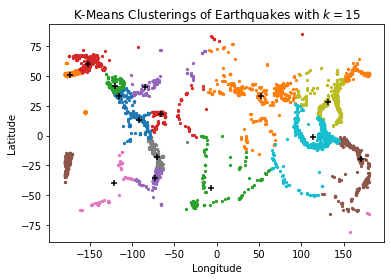

In [264]:
# plot the different clusters
u_labels = np.unique(clusterings)
for i in u_labels:
    plt.scatter(quakes[clusterings == i, 0], quakes[clusterings == i, 1], label = 'cluster ' + str(i), s=5)
    plt.scatter(centers[i,0], centers[i,1], marker='+', color='black')
#plt.legend(prop={'size': 7.5})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusterings of Earthquakes with $k=$' + str(k_means.n_clusters))
plt.show()

## Problem 4

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [247]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    w, h, d = tuple(im.shape)
    # Flatten the image
    image_array = np.reshape(im, (w * h, d))
    
    # Take a random sample from the array to use in KMeans
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
    kmeans = KMeans(n_clusters).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    
    # Reshape the image
    new_image = image_array_sample[labels].reshape(w,h,-1)
    return new_image
    

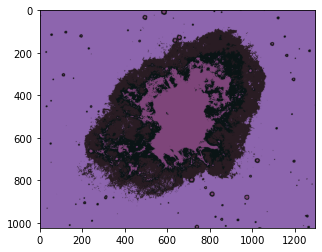

In [248]:
# Test with crab nebula image
crab = imageio.imread('nasa/crab_nebula.jpg')
new_image = quantize_image(crab)
plt.imshow(new_image)
plt.show()

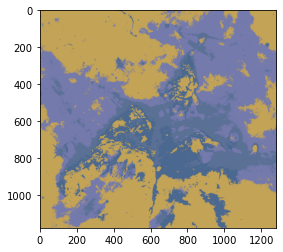

In [249]:
# Test with mystic mountain image
mtn = imageio.imread('nasa/mystic_mountain.jpg')
new_image = quantize_image(mtn)
plt.imshow(new_image)
plt.show()

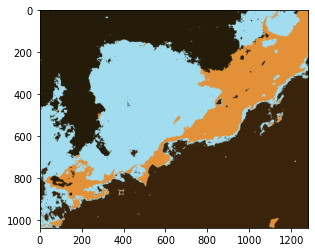

In [250]:
# Test with omega nebula image
omega = imageio.imread('nasa/omega_nebula.jpg')
new_image = quantize_image(omega)
plt.imshow(new_image)
plt.show()